# Using Kqlmagic to analyze Azure SQL logs and metrics

Written by:  Julie Koesmarno

Original Notebook: [Using Kqlmagic to analyze Azure SQL logs and metrics](https://github.com/MsSQLGirl/jubilant-data-wizards/blob/main/Simple%20Demo/Parameterization/SQLDBLog/AzureSQLLogsAndMetricsWithLogAnalytics.ipynb)

Modifed by: Taiob  Ali  

  

There are two main tables in Azure Log Analytics (Azure Monitor Logs) workspace that capture Azure SQL events:

1. AzureDiagnostics
2. AzureMetric

## 1. Connect to Log Analytics workspace

Workspace is similar to what a database is to SQL. You connect to Log Analytics workspace to start querying data. 

### 1.1 Load Kqlmagic
Need to load Kqlmagic first before we can start writing queries.

In [5]:
!pip install Kqlmagic --no-cache-dir --upgrade


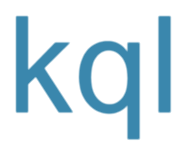

In [1]:
%reload_ext Kqlmagic

### 1.2 Connect to the desired Log Analytics workspace

In [20]:
# Initialize workspace ID to connect to, to analyzie Azure SQL log data

workspaceID = 'e54e4c50-7ddf-460f-8ce7-a11763455210'

In [21]:
%kql loganalytics://code;workspace=workspaceID;alias="Sqlalertdemo2" -try-azcli_login //-!se

## 2. Analyze events by Diagnostic Settings

Let's do a simple query first to analyze the number of events by Operation Name. 

> **Note**: Each row in AzureDiagnostic represents an event for specific Operation or category. Some SQL actions may result in generating multiple events of different types.



In [22]:
%%kql 
AzureDiagnostics
| summarize count() by OperationName

,OperationName,count_
0,AuditEvent,237
1,ErrorEvent,1
2,QueryStoreWaitStatisticsEvent,8
3,QueryStoreRuntimeStatisticsEvent,2


[{'OperationName': 'AuditEvent', 'count_': 237},
 {'OperationName': 'ErrorEvent', 'count_': 1},
 {'OperationName': 'QueryStoreWaitStatisticsEvent', 'count_': 8},
 {'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'count_': 2}]


The above query's equivalent in SQL is:
```
SELECT COUNT(*) AS [count_]
FROM AzureDiagnostics
GROUP BY OperationName
```


Count my Azure SQL DB events by category / diagnostic settings.

In [24]:
%%kql 
AzureDiagnostics
| where LogicalServerName_s == "sqlalertdemoserver"
| where TimeGenerated >= ago(5d)
| summarize count() by Category
| render barchart with (title = "Azure SQL DB Diagnostic Category")

[{'Category': 'SQLSecurityAuditEvents', 'count_': 237},
 {'Category': 'Errors', 'count_': 1},
 {'Category': 'QueryStoreWaitStatistics', 'count_': 8},
 {'Category': 'QueryStoreRuntimeStatistics', 'count_': 2}]

## 3. Performance troubleshooting Query (from Azure Portal)

Potentially a query or deadlock on the system that could lead to poor performance. The following is a query suggested by Azure Portal.

In [27]:
%%kql 
AzureMetrics
| where ResourceProvider == "MICROSOFT.SQL"
| where TimeGenerated >=ago(1d)
| where MetricName in ('deadlock')
| parse _ResourceId with * "/microsoft.sql/servers/" Resource // subtract Resource name for _ResourceId
| summarize Deadlock_max_60Mins = max(Maximum) by Resource, MetricName

,Resource,MetricName,Deadlock_max_60Mins


[]

# AzureMetrics

This is a sample query to dig into AzureMetrics

In [28]:
%%kql 
AzureMetrics
| project-away TenantId, ResourceId, SubscriptionId, _ResourceId, ResourceGroup // Don't show sensitive columns :) 
| project TimeGenerated, MetricName, Total, Count, UnitName
| take 10


,TimeGenerated,MetricName,Total,Count,UnitName
0,2021-05-11 18:45:00+00:00,storage,21430272.0,1.0,Bytes
1,2021-05-11 18:45:00+00:00,physical_data_read_percent,0.0,4.0,Percent
2,2021-05-11 18:45:00+00:00,dtu_limit,10.0,1.0,Count
3,2021-05-11 18:45:00+00:00,log_write_percent,0.0,4.0,Percent
4,2021-05-11 18:45:00+00:00,cpu_percent,0.0,4.0,Percent
5,2021-05-11 18:45:00+00:00,dtu_consumption_percent,0.0,4.0,Percent
6,2021-05-11 18:45:00+00:00,xtp_storage_percent,0.0,4.0,Percent
7,2021-05-11 18:45:00+00:00,workers_percent,0.0,4.0,Percent
8,2021-05-11 18:45:00+00:00,connection_successful,1.0,1.0,Count
9,2021-05-11 18:45:00+00:00,storage_percent,0.0,1.0,Percent


[{'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'storage', 'Total': 21430272, 'Count': 1, 'UnitName': 'Bytes'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'physical_data_read_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'dtu_limit', 'Total': 10, 'Count': 1, 'UnitName': 'Count'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'log_write_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'cpu_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'dtu_consumption_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'xtp_storage_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'workers_percent', 'Total': 0, 'Count': 4, 'UnitName': 'Percent'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'connection_successful', 'Total': 1, 'Count': 1, 'UnitName': 'Count'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, tzinfo=tzutc()), 'MetricName': 'storage_percent', 'Total': 0, 'Count': 1, 'UnitName': 'Percent'}]

# AzureDiagnostics

This is a sample query to dig into AzureDiagnostics. This table tends to have more details than AzureMetrics.

In [29]:
%%kql 
AzureDiagnostics
| project-away TenantId, ResourceId, SubscriptionId, ResourceGroup, _ResourceId // Don't show sensitive columns :) 
| take 10

,TimeGenerated,Category,ResourceProvider,Resource,ResourceType,OperationName,ResultType,CorrelationId,ResultDescription,Tenant_g,JobId_g,RunbookName_s,StreamType_s,Caller_s,requestUri_s,Level,DurationMs,CallerIPAddress,OperationVersion,ResultSignature,id_s,status_s,LogicalServerName_s,Message,clientInfo_s,httpStatusCode_d,identity_claim_appid_g,identity_claim_http_schemas_microsoft_com_identity_claims_objectidentifier_g,userAgent_s,ruleName_s,identity_claim_http_schemas_xmlsoap_org_ws_2005_05_identity_claims_upn_s,systemId_g,isAccessPolicyMatch_b,EventName_s,httpMethod_s,subnetId_s,type_s,instanceId_s,macAddress_s,vnetResourceGuid_g,direction_s,subnetPrefix_s,primaryIPv4Address_s,conditions_sourcePortRange_s,priority_d,conditions_destinationPortRange_s,conditions_destinationIP_s,conditions_None_s,conditions_sourceIP_s,httpVersion_s,matchedConnections_d,startTime_t,endTime_t,DatabaseName_s,clientIP_s,host_s,requestQuery_s,sslEnabled_s,clientPort_d,httpStatus_d,receivedBytes_d,sentBytes_d,timeTaken_d,resultDescription_ErrorJobs_s,resultDescription_ChildJobs_s,identity_claim_http_schemas_microsoft_com_identity_claims_scope_s,workflowId_s,resource_location_s,resource_workflowId_g,resource_resourceGroupName_s,resource_subscriptionId_g,resource_runId_s,resource_workflowName_s,_schema_s,correlation_clientTrackingId_s,properties_sku_Family_s,properties_sku_Name_s,properties_tenantId_g,properties_enabledForDeployment_b,code_s,resultDescription_Summary_MachineId_s,resultDescription_Summary_ScheduleName_s,resultDescription_Summary_Status_s,resultDescription_Summary_StatusDescription_s,resultDescription_Summary_MachineName_s,resultDescription_Summary_TotalUpdatesInstalled_d,resultDescription_Summary_RebootRequired_b,resultDescription_Summary_TotalUpdatesFailed_d,resultDescription_Summary_InstallPercentage_d,resultDescription_Summary_StartDateTimeUtc_t,resource_triggerName_s,resultDescription_Summary_InitialRequiredUpdatesCount_d,properties_enabledForTemplateDeployment_b,resultDescription_Summary_EndDateTimeUtc_s,resultDescription_Summary_DurationInMinutes_s,resource_originRunId_s,properties_enabledForDiskEncryption_b,resource_actionName_s,correlation_actionTrackingId_g,resultDescription_Summary_EndDateTimeUtc_t,resultDescription_Summary_DurationInMinutes_d,conditions_protocols_s,identity_claim_ipaddr_s,ElasticPoolName_s,identity_claim_http_schemas_microsoft_com_claims_authnmethodsreferences_s,RunOn_s,query_hash_s,SourceSystem,MG,ManagementGroupName,Computer,RawData,exec_type_d,wait_category_s,total_query_wait_time_ms_d,max_query_wait_time_ms_d,is_parameterizable_s,statement_type_s,statement_key_hash_s,query_param_type_d,interval_start_time_d,interval_end_time_d,logical_io_writes_d,max_logical_io_writes_d,physical_io_reads_d,max_physical_io_reads_d,logical_io_reads_d,max_logical_io_reads_d,execution_type_d,count_executions_d,cpu_time_d,max_cpu_time_d,dop_d,max_dop_d,rowcount_d,max_rowcount_d,query_max_used_memory_d,max_query_max_used_memory_d,duration_d,max_duration_d,num_physical_io_reads_d,max_num_physical_io_reads_d,log_bytes_used_d,max_log_bytes_used_d,query_id_d,plan_id_d,statement_sql_handle_s,query_plan_hash_s,error_number_d,Severity,user_defined_b,state_d,originalEventTimestamp_t,audit_schema_version_d,event_time_t,sequence_number_d,action_id_s,action_name_s,succeeded_s,is_column_permission_s,session_id_d,server_principal_id_d,database_principal_id_d,target_server_principal_id_d,target_database_principal_id_d,object_id_d,user_defined_event_id_d,transaction_id_d,class_type_s,class_type_description_s,securable_class_type_s,duration_milliseconds_d,response_rows_d,affected_rows_d,client_tls_version_d,client_ip_s,permission_bitmask_g,sequence_group_id_g,session_server_principal_name_s,server_principal_name_s,server_principal_sid_s,database_principal_name_s,target_server_principal_name_s,target_server_principal_sid_s,target_database_principal_name_s,server_instance_name_s,database_name_s,schema_name_s,object_name_s,statement_s,additional

[{'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 34, 32, 288000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'ResourceProvider': 'MICROSOFT.SQL', 'Resource': 'MASTER', 'ResourceType': 'SERVERS/DATABASES', 'OperationName': 'AuditEvent', 'ResultType': '', 'CorrelationId': '', 'ResultDescription': '', 'Tenant_g': '', 'JobId_g': '', 'RunbookName_s': '', 'StreamType_s': '', 'Caller_s': '', 'requestUri_s': '', 'Level': '', 'DurationMs': None, 'CallerIPAddress': '', 'OperationVersion': '', 'ResultSignature': '', 'id_s': '', 'status_s': '', 'LogicalServerName_s': 'sqlalertdemoserver', 'Message': '', 'clientInfo_s': '', 'httpStatusCode_d': None, 'identity_claim_appid_g': '', 'identity_claim_http_schemas_microsoft_com_identity_claims_objectidentifier_g': '', 'userAgent_s': '', 'ruleName_s': '', 'identity_claim_http_schemas_xmlsoap_org_ws_2005_05_identity_claims_upn_s': '', 'systemId_g': '', 'isAccessPolicyMatch_b': None, 'EventName_s': '', 'httpMethod_s': '', 'subnetId_s': '', 'type_s': '', 'instanceId_s': '', 'macAddress_s': '', 'vnetResourceGuid_g': '', 'direction_s': '', 'subnetPrefix_s': '', 'primaryIPv4Address_s': '', 'conditions_sourcePortRange_s': '', 'priority_d': None, 'conditions_destinationPortRange_s': '', 'conditions_destinationIP_s': '', 'conditions_None_s': '', 'conditions_sourceIP_s': '', 'httpVersion_s': '', 'matchedConnections_d': None, 'startTime_t': None, 'endTime_t': None, 'DatabaseName_s': '', 'clientIP_s': '', 'host_s': '', 'requestQuery_s': '', 'sslEnabled_s': '', 'clientPort_d': None, 'httpStatus_d': None, 'receivedBytes_d': None, 'sentBytes_d': None, 'timeTaken_d': None, 'resultDescription_ErrorJobs_s': '', 'resultDescription_ChildJobs_s': '', 'identity_claim_http_schemas_microsoft_com_identity_claims_scope_s': '', 'workflowId_s': '', 'resource_location_s': '', 'resource_workflowId_g': '', 'resource_resourceGroupName_s': '', 'resource_subscriptionId_g': '', 'resource_runId_s': '', 'resource_workflowName_s': '', '_schema_s': '', 'correlation_clientTrackingId_s': '', 'properties_sku_Family_s': '', 'properties_sku_Name_s': '', 'properties_tenantId_g': '', 'properties_enabledForDeployment_b': None, 'code_s': '', 'resultDescription_Summary_MachineId_s': '', 'resultDescription_Summary_ScheduleName_s': '', 'resultDescription_Summary_Status_s': '', 'resultDescription_Summary_StatusDescription_s': '', 'resultDescription_Summary_MachineName_s': '', 'resultDescription_Summary_TotalUpdatesInstalled_d': None, 'resultDescription_Summary_RebootRequired_b': None, 'resultDescription_Summary_TotalUpdatesFailed_d': None, 'resultDescription_Summary_InstallPercentage_d': None, 'resultDescription_Summary_StartDateTimeUtc_t': None, 'resource_triggerName_s': '', 'resultDescription_Summary_InitialRequiredUpdatesCount_d': None, 'properties_enabledForTemplateDeployment_b': None, 'resultDescription_Summary_EndDateTimeUtc_s': '', 'resultDescription_Summary_DurationInMinutes_s': '', 'resource_originRunId_s': '', 'properties_enabledForDiskEncryption_b': None, 'resource_actionName_s': '', 'correlation_actionTrackingId_g': '', 'resultDescription_Summary_EndDateTimeUtc_t': None, 'resultDescription_Summary_DurationInMinutes_d': None, 'conditions_protocols_s': '', 'identity_claim_ipaddr_s': '', 'ElasticPoolName_s': '', 'identity_claim_http_schemas_microsoft_com_claims_authnmethodsreferences_s': '', 'RunOn_s': '', 'query_hash_s': '', 'SourceSystem': 'Azure', 'MG': '', 'ManagementGroupName': '', 'Computer': '', 'RawData': '', 'exec_type_d': None, 'wait_category_s': '', 'total_query_wait_time_ms_d': None, 'max_query_wait_time_ms_d': None, 'is_parameterizable_s': '', 'statement_type_s': '', 'statement_key_hash_s': '', 'query_param_type_d': None, 'interval_start_time_d': None, 'interval_end_time_d': None, 'logical_io_writes_d': None, 'max_logical_io_writes_d': None, 'physical_io_reads_d': None, 'max_physical_io_reads_d': None, 'logical_io_reads_d': None, 'max_logical_io_reads_d': None, 'execution_type_d': None, 'count_executions_d': No

## Analyze (non-audit) Events

In [30]:
%%kql 
AzureDiagnostics
| summarize event_count=count() by bin(TimeGenerated, 2d), OperationName
| where OperationName <> "AuditEvent"
| render timechart 

[{'TimeGenerated': datetime.datetime(2021, 5, 11, 0, 0, tzinfo=tzutc()), 'OperationName': 'ErrorEvent', 'event_count': 1},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreWaitStatisticsEvent', 'event_count': 8},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 0, 0, tzinfo=tzutc()), 'OperationName': 'QueryStoreRuntimeStatisticsEvent', 'event_count': 2}]

## Deadlock Analysis

In [34]:
%%kql 
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| project TimeGenerated, Category, Resource, OperationName, Type, deadlock_xml_s
| sort by TimeGenerated desc
| take 50

,TimeGenerated,Category,Resource,OperationName,Type,deadlock_xml_s
0,2021-05-11 19:17:31.022000+00:00,Deadlocks,SQLALERTDEMODATABASE,DeadlockEvent,AzureDiagnostics,<deadlock> <victim-list> <victimProcess i...


[{'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 17, 31, 22000, tzinfo=tzutc()), 'Category': 'Deadlocks', 'Resource': 'SQLALERTDEMODATABASE', 'OperationName': 'DeadlockEvent', 'Type': 'AzureDiagnostics', 'deadlock_xml_s': "<deadlock>   <victim-list>    <victimProcess id='process1d2fe23e8c8'/>   </victim-list>   <process-list>    <process id='process1d2fe23e8c8' taskpriority='0' logused='400' waitresource='RID: 5:1:2520:0' waittime='7905' ownerId='23813' transactionname='user_transaction' lasttranstarted='2021-05-11T19:17:23.113' XDES='0x1d30cb24428' lockMode='U' schedulerid='2' kpid='79052' status='suspended' spid='83' sbid='0' ecid='0' priority='0' trancount='2' lastbatchstarted='2021-05-11T19:17:23.100' lastbatchcompleted='2021-05-11T19:17:23.080' lastattention='1900-01-01T00:00:00.080' clientapp='Microsoft SQL Server Management Studio - Query' hostname='filtered' hostpid='19340' loginname='filtered' isolationlevel='read committed (2)' xactid='23813' currentdb='5' currentdbname='sqlalertdemodatabase' lockTimeout='4294967295' clientoption1='671090784' clientoption2='390200'>     <executionStack>      <frame procname='unknown' queryhash='0xe0232a262dc67058' queryplanhash='0xdcd040c7146d60d5' line='6' stmtstart='60' stmtend='182' sqlhandle='0x020000000dd33a257162883d0eb23f28478788ae94f7050f0000000000000000000000000000000000000000'>  unknown    </frame>      <frame procname='unknown' queryhash='0xe0232a262dc67058' queryplanhash='0xdcd040c7146d60d5' line='6' stmtstart='172' stmtend='300' sqlhandle='0x020000009659ad00999afc1eb4baf53803f2a5b9d463522b0000000000000000000000000000000000000000'>  unknown    </frame>     </executionStack>     <inputbuf>  filtered   </inputbuf>    </process>    <process id='process1d2fd4c5088' taskpriority='0' logused='412' waitresource='RID: 5:1:2656:0' waittime='3635' ownerId='23730' transactionname='user_transaction' lasttranstarted='2021-05-11T19:17:16.983' XDES='0x1d30cb20428' lockMode='U' schedulerid='1' kpid='51856' status='suspended' spid='81' sbid='0' ecid='0' priority='0' trancount='2' lastbatchstarted='2021-05-11T19:17:27.380' lastbatchcompleted='2021-05-11T19:17:27.353' lastattention='1900-01-01T00:00:00.353' clientapp='Microsoft SQL Server Management Studio - Query' hostname='filtered' hostpid='19340' loginname='filtered' isolationlevel='read committed (2)' xactid='23730' currentdb='5' currentdbname='sqlalertdemodatabase' lockTimeout='4294967295' clientoption1='671088672' clientoption2='128056'>     <executionStack>      <frame procname='unknown' queryhash='0x676ea57babf90844' queryplanhash='0x367a5f67ca046cf8' line='1' stmtstart='60' stmtend='188' sqlhandle='0x02000000f884070d8f0d33f9b405b730b28122c6252139430000000000000000000000000000000000000000'>  unknown    </frame>      <frame procname='unknown' queryhash='0x676ea57babf90844' queryplanhash='0x367a5f67ca046cf8' line='1' stmtend='134' sqlhandle='0x0200000034796107b36d645a2f7c431d975800f2aeee05900000000000000000000000000000000000000000'>  unknown    </frame>     </executionStack>     <inputbuf>  filtered   </inputbuf>    </process>   </process-list>   <resource-list>    <ridlock fileid='1' pageid='2520' dbid='5' objectname='filtered' id='lock1d305af3100' mode='X' associatedObjectId='72057594044153856'>     <owner-list>      <owner id='process1d2fd4c5088' mode='X'/>     </owner-list>     <waiter-list>      <waiter id='process1d2fe23e8c8' mode='U' requestType='wait'/>     </waiter-list>    </ridlock>    <ridlock fileid='1' pageid='2656' dbid='5' objectname='filtered' id='lock1d305af6400' mode='X' associatedObjectId='72057594044219392'>     <owner-list>      <owner id='process1d2fe23e8c8' mode='X'/>     </owner-list>     <waiter-list>      <waiter id='process1d2fd4c5088' mode='U' requestType='wait'/>     </waiter-list>    </ridlock>   </resource-list>  </deadlock>  "}]

Find the deadlock query plan

In [33]:
%%kql 
AzureDiagnostics
| where OperationName == "DeadlockEvent"
| extend d = parse_xml(deadlock_xml_s)
| project TimeGenerated, QuerhPlanHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryplanhash"], QueryHash = d.deadlock.["process-list"].process[0].executionStack.frame[0]["@queryhash"]
//| sort by TimeGenerated desc
| take 50

,TimeGenerated,QuerhPlanHash,QueryHash
0,2021-05-11 19:17:31.022000+00:00,0xdcd040c7146d60d5,0xe0232a262dc67058


[{'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 17, 31, 22000, tzinfo=tzutc()), 'QuerhPlanHash': '0xdcd040c7146d60d5', 'QueryHash': '0xe0232a262dc67058'}]

## Query Store Runtime Statistics Events

In [35]:
%%kql 
AzureDiagnostics
| where OperationName == "QueryStoreRuntimeStatisticsEvent"
| project TimeGenerated, query_hash_s, statement_sql_handle_s, query_plan_hash_s
| take 50

,TimeGenerated,query_hash_s,statement_sql_handle_s,query_plan_hash_s
0,2021-05-11 19:22:24.560000+00:00,0x3D251D2A95CEE0FA,0x0900769CEE691C933F258772430BD1146CFF00000000...,0xBF28FE55E8A5616A
1,2021-05-11 19:22:24.560000+00:00,0x4E8C0B5AF78C4ED1,0x0900C6D4FC50EF5B4E298DBE4E3A7EA7911F00000000...,0x132EFB64A54855E5
2,2021-05-11 18:45:55.469000+00:00,0x3D251D2A95CEE0FA,0x0900769CEE691C933F258772430BD1146CFF00000000...,0xBF28FE55E8A5616A
3,2021-05-11 18:45:55.469000+00:00,0x4E8C0B5AF78C4ED1,0x0900C6D4FC50EF5B4E298DBE4E3A7EA7911F00000000...,0x132EFB64A54855E5


[{'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 22, 24, 560000, tzinfo=tzutc()), 'query_hash_s': '0x3D251D2A95CEE0FA', 'statement_sql_handle_s': '0x0900769CEE691C933F258772430BD1146CFF0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xBF28FE55E8A5616A'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 22, 24, 560000, tzinfo=tzutc()), 'query_hash_s': '0x4E8C0B5AF78C4ED1', 'statement_sql_handle_s': '0x0900C6D4FC50EF5B4E298DBE4E3A7EA7911F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x132EFB64A54855E5'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, 55, 469000, tzinfo=tzutc()), 'query_hash_s': '0x3D251D2A95CEE0FA', 'statement_sql_handle_s': '0x0900769CEE691C933F258772430BD1146CFF0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0xBF28FE55E8A5616A'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 45, 55, 469000, tzinfo=tzutc()), 'query_hash_s': '0x4E8C0B5AF78C4ED1', 'statement_sql_handle_s': '0x0900C6D4FC50EF5B4E298DBE4E3A7EA7911F0000000000000000000000000000000000000000000000000000', 'query_plan_hash_s': '0x132EFB64A54855E5'}]

## Analyze Errors

In [36]:
%%kql 
AzureDiagnostics
| where OperationName == "ErrorEvent"
| extend ErrorNumber =  tostring(error_number_d) 
| summarize event_count=count() by EventTime = bin(TimeGenerated, 2d), ErrorNumber
| render timechart 

[{'EventTime': datetime.datetime(2021, 5, 11, 0, 0, tzinfo=tzutc()), 'ErrorNumber': '208.0', 'event_count': 4}]

## Find Deleted table

In [37]:
%%kql 
AzureDiagnostics
| where action_name_s in ('BATCH COMPLETED')
| project TimeGenerated, Category, action_name_s, statement_s
| where statement_s contains "DROP TABLE"
| sort by TimeGenerated desc 
| take 10



,TimeGenerated,Category,action_name_s,statement_s
0,2021-05-11 19:17:48.244000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE IF EXISTS dbo.dt_Employees\r\n
1,2021-05-11 19:17:48.244000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE IF EXISTS dbo.dt_Suppliers;\r\n
2,2021-05-11 19:17:13.228000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,\r\nDROP TABLE IF EXISTS dbo.dt_Suppliers;\r\n
3,2021-05-11 19:17:13.228000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE IF EXISTS dbo.dt_Employees;\r\n
4,2021-05-11 18:38:46.338000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE IF EXISTS dbo.dt_Suppliers;\r\nDROP...
5,2021-05-11 18:37:33.337000+00:00,SQLSecurityAuditEvents,BATCH COMPLETED,DROP TABLE IF EXISTS dbo.dt_Employees;\r\n\r\n...


[{'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 17, 48, 244000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE IF EXISTS dbo.dt_Employees\r\n'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 17, 48, 244000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE IF EXISTS dbo.dt_Suppliers;\r\n'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 17, 13, 228000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': '\r\nDROP TABLE IF EXISTS dbo.dt_Suppliers;\r\n'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 19, 17, 13, 228000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE IF EXISTS dbo.dt_Employees;\r\n'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 38, 46, 338000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': 'DROP TABLE IF EXISTS dbo.dt_Suppliers;\r\nDROP TABLE IF EXISTS dbo.dt_Employees;'},
 {'TimeGenerated': datetime.datetime(2021, 5, 11, 18, 37, 33, 337000, tzinfo=tzutc()), 'Category': 'SQLSecurityAuditEvents', 'action_name_s': 'BATCH COMPLETED', 'statement_s': "DROP TABLE IF EXISTS dbo.dt_Employees;\r\n\r\nCREATE TABLE dbo.dt_Employees (\r\n    EmpId INT IDENTITY,\r\n    EmpName VARCHAR(16),\r\n    Phone VARCHAR(16)\r\n);\r\n\r\nINSERT INTO dbo.dt_Employees (EmpName, Phone)\r\nVALUES ('Martha', '800-555-1212'), ('Jimmy', '619-555-8080');\r\n\r\nDROP TABLE IF EXISTS dbo.dt_Suppliers;\r\n\r\nCREATE TABLE dbo.dt_Suppliers(\r\n    SupplierId INT IDENTITY,\r\n    SupplierName VARCHAR(64),\r\n    Fax VARCHAR(16)\r\n);\r\n\r\nINSERT INTO dbo.dt_Suppliers (SupplierName, Fax)\r\nVALUES ('Acme', '877-555-6060'), ('Rockwell', '800-257-1234');"}]